https://www.kaggle.com/code/diegoambrosiovieira/16k-metacr-tic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import spacy as sp
from bs4 import BeautifulSoup
import re

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [2]:
 sp.prefer_gpu()

False

In [4]:
import os
os.chdir(r'E:\Python code\16000+ Movies 1910-2024 (Metacritic)')

In [5]:
path = "16k_Movies.csv"

data = pd.read_csv(path).drop("Unnamed: 0", axis=1)
data.dropna(inplace=True)#删除空值
data.drop_duplicates(inplace=True)#删除重复的行
data.head()

,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Written by,Duration,Genres
0,Dekalog (1988),"Mar 22, 1996",This masterwork by Krzysztof Kieślowski is one...,7.4,118,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz",9 h 32 m,Drama
1,Three Colors: Red,"Nov 23, 1994",Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz, Ag...",1 h 39 m,"Drama,Mystery,Romance"
2,The Conformist,"Oct 22, 1970","Set in Rome in the 1930s, this re-release of B...",7.3,106,Bernardo Bertolucci,"Alberto Moravia, Bernardo Bertolucci",1 h 47 m,Drama
3,Tokyo Story,"Mar 13, 1972",Yasujiro Ozu’s Tokyo Story follows an aging co...,8.1,147,Yasujirô Ozu,"Kôgo Noda, Yasujirô Ozu",2 h 16 m,Drama
4,The Leopard (re-release),"Aug 13, 2004","Set in Sicily in 1860, Luchino Visconti's spec...",7.8,85,Luchino Visconti,"Giuseppe Tomasi di Lampedusa, Suso Cecchi D'Am...",3 h 7 m,"Drama,History"


# data processing

In [6]:
data["No of Persons Voted"] = data["No of Persons Voted"].str.replace(",", "")
data["No of Persons Voted"] = data["No of Persons Voted"].astype(int)
data['Release Date'] = pd.to_datetime(data['Release Date'], errors='coerce')
data = data.assign(Genres=data.Genres.str.split(',')).explode('Genres')#assign添加新的一列 
#"explode" 这个术语通常用于描述将一个列表（或者其他可迭代对象）中的每个元素拆分或扩展为单独的行。
data['Genres'] = data['Genres'].str.strip()

In [8]:
print("Mean", data["No of Persons Voted"].mean())
print("Median", data["No of Persons Voted"].median())
print("Max", data["No of Persons Voted"].max())
print("Min", data["No of Persons Voted"].min())

Mean 161.31586590826575
Median 43.0
Max 10639
Min 4


In [9]:
df = data[data["No of Persons Voted"] >= 100]
director_counts = df["Directed by"].value_counts()
df = df[df["Directed by"].isin(director_counts[director_counts >= 4].index)]
df.head()

,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Written by,Duration,Genres
0,Dekalog (1988),1996-03-22,This masterwork by Krzysztof Kieślowski is one...,7.4,118,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz",9 h 32 m,Drama
1,Three Colors: Red,1994-11-23,Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz, Ag...",1 h 39 m,Drama
1,Three Colors: Red,1994-11-23,Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz, Ag...",1 h 39 m,Mystery
1,Three Colors: Red,1994-11-23,Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz, Ag...",1 h 39 m,Romance
5,The Godfather,1972-03-24,Francis Ford Coppola's epic features Marlon Br...,9.3,4102,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",2 h 55 m,Crime


In [10]:
data_group = df.groupby("Directed by")["Rating"].mean()
data_group = data_group.sort_values(ascending=False)[:30]
data_group

Directed by
Hal Ashby                                                                          9.700000
Hadi Hajaig                                                                        9.600000
Andrea Di Stefano                                                                  9.500000
Terry L. Noss, \n    \n      Richard Rich                                          9.500000
Swati Bhise                                                                        9.500000
D.M.W. Greer                                                                       9.500000
Andrew Morahan                                                                     9.400000
Kenneth Johnson                                                                    9.400000
Jim Sonzero                                                                        9.300000
Randall Miller                                                                     9.300000
Alain Berliner                                                      

In [11]:
def movies_directed_by(name):
    movies = df[df["Directed by"] == name]
    movies = movies.sort_values(by="Rating", ascending=False)
    return movies.drop("Directed by",axis=1)

In [12]:
movies_directed_by("Hayao Miyazaki")

,Title,Release Date,Description,Rating,No of Persons Voted,Written by,Duration,Genres
27,Spirited Away,2002-09-20,"A young girl, Chihiro, becomes trapped in a st...",8.8,1850,Hayao Miyazaki,2 h 5 m,Animation
27,Spirited Away,2002-09-20,"A young girl, Chihiro, becomes trapped in a st...",8.8,1850,Hayao Miyazaki,2 h 5 m,Adventure
27,Spirited Away,2002-09-20,"A young girl, Chihiro, becomes trapped in a st...",8.8,1850,Hayao Miyazaki,2 h 5 m,Family
27,Spirited Away,2002-09-20,"A young girl, Chihiro, becomes trapped in a st...",8.8,1850,Hayao Miyazaki,2 h 5 m,Fantasy
27,Spirited Away,2002-09-20,"A young girl, Chihiro, becomes trapped in a st...",8.8,1850,Hayao Miyazaki,2 h 5 m,Mystery
2821,Princess Mononoke,1999-10-29,The mythological tale of a war between encroac...,8.7,629,"Hayao Miyazaki, Neil Gaiman",2 h 14 m,Adventure
2821,Princess Mononoke,1999-10-29,The mythological tale of a war between encroac...,8.7,629,"Hayao Miyazaki, Neil Gaiman",2 h 14 m,Action
2821,Princess Mononoke,1999-10-29,The mythological tale of a war between encroac...,8.7,629,"Hayao Miyazaki, Neil Gaiman",2 h 14 m,Animation
2821,Princess Mononoke,1999-10-29,The mythological tale of a war between encroac...,8.7,629,"Hayao Miyazaki, Neil Gaiman",2 h 14 m,Fantasy
1303,Howl's Moving Castle,2005-06-10,An amazing new animated adventure that celebra...,8.6,525,"Hayao Miyazaki, Diana Wynne Jones",1 h 59 m,Fantasy


In [13]:
def get_top_movies_by_genre(genre, dataframe=df, top=5):
    # Filter movies by genre
    movies = dataframe[dataframe["Genres"].str.contains(
        genre, case=False, na=False)]

    # Sort movies by 'No of Persons Voted'
    movies = movies.sort_values(by="Rating", ascending=False)

    # Remove duplicates based on 'Title'
    movies.drop_duplicates(subset=['Title'], inplace=True)#删除重复额列

    # Select top N movies and drop the 'Genres' column
    movies = movies.head(top).drop("Genres", axis=1)

    # Reset the index and return the dataframe
    return movies.reset_index(drop=True)

In [14]:
get_top_movies_by_genre(genre="Horror", top=10)

,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Written by,Duration
0,Pulse,2005-08-12,Two groups of people discover evidence that su...,9.3,1106,Jim Sonzero,"Kiyoshi Kurosawa, Wes Craven, Ray Wright",1 h 30 m
1,God Is a Bullet,2023-06-23,When vice detective Bob Hightower (Nikolaj Cos...,9.3,263,Nick Cassavetes,"Boston Teran, Nick Cassavetes",2 h 35 m
2,Argento's Dracula 3D,2013-10-04,"At the home of Lucy (Asia Argento), a photogra...",9.2,153,Dario Argento,"Dario Argento, Enrique Cerezo, Stefano Piani, ...",1 h 46 m
3,Blood: The Last Vampire,2009-07-10,Blood: The Last Vampire is based on the cult h...,9.2,385,Chris Nahon,"Chris Chow, Mamoru Oshii",1 h 31 m
4,Tyler Perry's Acrimony,2018-03-30,A faithful wife (Taraji P. Henson) tired of st...,9.1,321,Tyler Perry,Tyler Perry,2 h
5,Brahms: The Boy II,2020-02-21,Unaware of the terrifying history of Heelshire...,9.1,673,William Brent Bell,Stacey Menear,1 h 26 m
6,Alien,1979-06-22,For the first time in nearly a quarter-century...,9.0,1490,Ridley Scott,"Dan O'Bannon, Ronald Shusett",1 h 57 m
7,Cursed,2005-02-25,From the team that brought you the Scream tril...,9.0,552,Wes Craven,Kevin Williamson,1 h 37 m
8,Dawn of the Dead,2004-03-19,In this remake of George A. Romero's horror cl...,8.8,805,Zack Snyder,"George A. Romero, James Gunn",1 h 41 m
9,Hatchet II,2010-10-01,"Marybeth escapes the clutches of the deformed,...",8.8,123,Adam Green,Adam Green,1 h 29 m


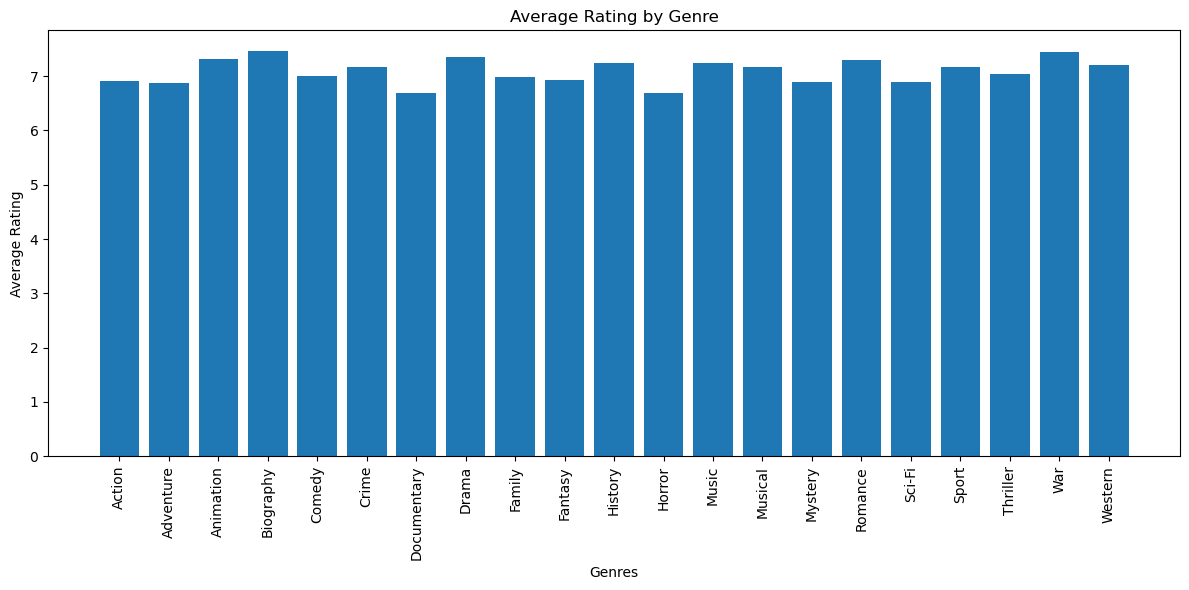

In [15]:
genre_ratings = df.groupby('Genres')['Rating'].mean()

plt.figure(figsize=(12, 6))#设置图像的大小
plt.bar(genre_ratings.index, genre_ratings.values)
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title('Average Rating by Genre')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
nlp = sp.load("en_core_web_sm")#加载模型

In [17]:
def clean_text(text):
    # Remove multiple spaces and leading/trailing spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Convert to lowercase
    text = text.lower()

    # Tokenize with spaCy and remove stop words and punctuation
    doc = nlp(text)
    words = [token.text for token in doc if not token.is_stop and not token.is_punct]

    # Join the remaining words into a string
    description = " ".join(words)

    return description

In [18]:
example = data["Description"][0]
print(example)
print()
print(clean_text(example))

This masterwork by Krzysztof Kieślowski is one of the twentieth century’s greatest achievements in visual storytelling. Originally made for Polish television, Dekalog focuses on the residents of a housing complex in late-Communist Poland, whose lives become subtly intertwined as they face emotional dilemmas that are at once deeply personal and universally human. Its ten hour-long films, drawing from the Ten Commandments for thematic inspiration and an overarching structure, grapple deftly with complex moral and existential questions concerning life, death, love, hate, truth, and the passage of time. Shot by nine different cinematographers, with stirring music by Zbigniew Preisner and compelling performances from established and unknown actors alike, Dekalog arrestingly explores the unknowable forces that shape our lives. Also available are the longer theatrical versions of the series’ fifth and sixth films: A Short Film About Killing and A Short Film About Love. [Janus Films]

masterwo

In [19]:
descriptions = df["Description"].apply(clean_text)
ratings = df["Rating"].values
ratings = ratings.reshape(-1, 1)

In [20]:
max_len = max(len(description.split()) for description in descriptions)
print(f'Maximum length of a description: {max_len}')

vectorizer = TextVectorization(output_mode='int', split='whitespace',
                               standardize='strip_punctuation', max_tokens=10000,
                               output_sequence_length=max_len)

vectorizer.adapt(descriptions)
print(f'Vocabulary size: {vectorizer.vocabulary_size()}')

Maximum length of a description: 144


Vocabulary size: 10000


# train model

In [21]:
def generate_dataset(descriptions_vectorized, score, buffer_size, batch_size, p):
    assert len(descriptions_vectorized) == len(score), "Features and labels must have the same length."
    assert 0 <= p <= 1, "p must be between 0 and 1."
    # Calculates the split size between training and testing
    size = int(p * len(descriptions_vectorized))

    # Creates the dataset from features and scores
    dataset = tf.data.Dataset.from_tensor_slices((descriptions_vectorized, score))

    dataset = dataset.shuffle(buffer_size=buffer_size)

    # Split the dataset into training and testing
    dataset_train = dataset.take(size)
    dataset_test = dataset.skip(size)

    # Apply batch and prefetch after split
    dataset_train = dataset_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    dataset_test = dataset_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset_train, dataset_test

In [23]:
descriptions_vectorized=vectorizer(descriptions)
buffer_size=10000
batch_size=32
p=0.8


train_df, test_df = generate_dataset(descriptions_vectorized=descriptions_vectorized,
                                      score=ratings,
                                      buffer_size=buffer_size,
                                      batch_size=batch_size,
                                      p=p)

In [24]:
def create_model(vocab_size, embedding_dim, rnn_units, lr=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True),
        tf.keras.layers.Dense(1)
      ])
    
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.Huber()

    model.compile(loss=loss,
                    optimizer=optim,
                    metrics=['mae', 'mse'])
    
    return model

In [25]:
vocab_size = vectorizer.vocabulary_size()
embedding_dim = 128
rnn_units = 128
model = create_model(vocab_size, embedding_dim, rnn_units)

In [26]:
patience = 5
verbose = 1
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=verbose)

In [27]:
history = model.fit(train_df,
                    epochs=10,
                    verbose=verbose,
                    validation_data=test_df,
                    callbacks=[early_stopping])

Epoch 1/10

242/242 [==============================] - 25s 93ms/step - loss: 1.0149 - mae: 1.4270 - mse: 4.5916 - val_loss: 0.7624 - val_mae: 1.1804 - val_mse: 2.3505
Epoch 2/10
242/242 [==============================] - 22s 92ms/step - loss: 0.6979 - mae: 1.1030 - mse: 2.1970 - val_loss: 0.6627 - val_mae: 1.0652 - val_mse: 2.0328
Epoch 3/10
242/242 [==============================] - 22s 92ms/step - loss: 0.6514 - mae: 1.0497 - mse: 1.9816 - val_loss: 0.5505 - val_mae: 0.9331 - val_mse: 1.6003
Epoch 4/10
242/242 [==============================] - 22s 92ms/step - loss: 0.3562 - mae: 0.6802 - mse: 1.0295 - val_loss: 0.2617 - val_mae: 0.5981 - val_mse: 0.6665
Epoch 5/10
242/242 [==============================] - 22s 90ms/step - loss: 0.1626 - mae: 0.3998 - mse: 0.4468 - val_loss: 0.1207 - val_mae: 0.3165 - val_mse: 0.3519
Epoch 6/10
242/242 [==============================] - 23s 94ms/step - loss: 0.0923 - mae: 0.2764 - mse: 0.2426 - val_loss: 0.0784 - val_mae: 0.2730 - val_mse: 0.1911
Epo

In [28]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

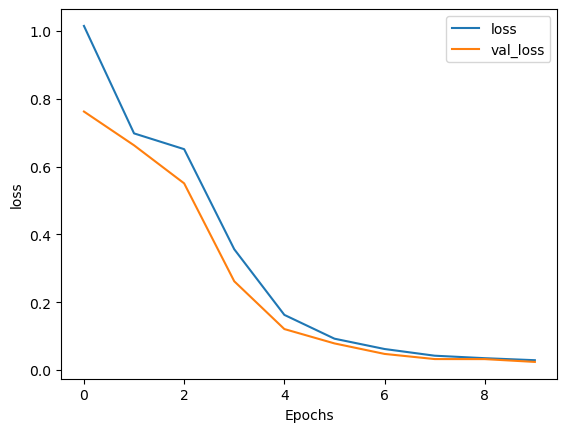

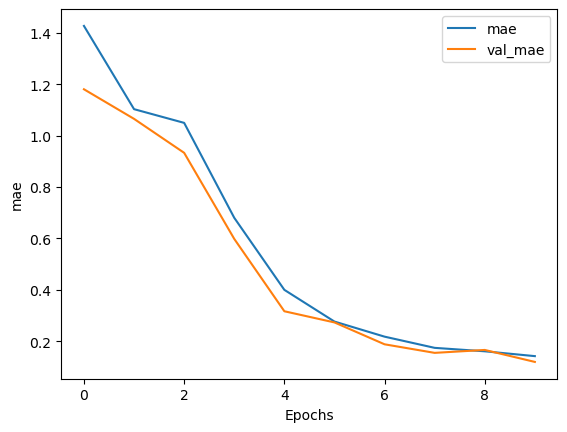

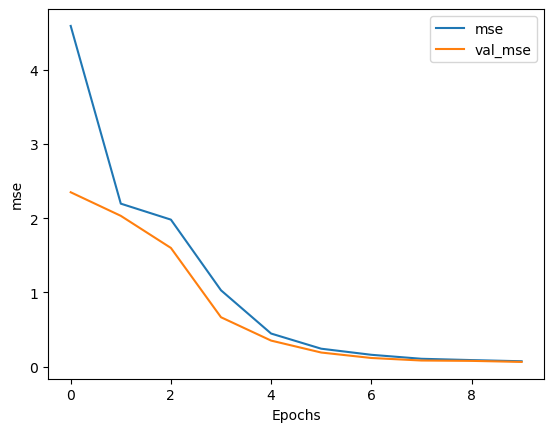

In [29]:
plot_history(history, 'loss')
plot_history(history, 'mae')
plot_history(history, 'mse')